In [15]:
import dml
from pymongo import MongoClient
import prov.model
import datetime
import json
import uuid
import folium
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [28]:
client = MongoClient()
db = client.repo
collection = db.jhs2018_rpm1995.kmeansdata
df = pd.DataFrame(list(collection.find()))

latitude = [0]*len(df)
longitude = [0]*len(df)
for i in range(len(df)):
    latitude[i] = df['coordinates'][i][0]
    longitude[i] = df['coordinates'][i][1]
    

df['latitude'] = latitude
df['longitude']= longitude
#df['reallat'] = reallat
#df['reallong'] = reallong
#df = df[(df.charge_count != 0)|(df.hubway_count != 0)|(df.open_count != 0)]

df[['charge_count','hubway_count','open_count','latitude','longitude', 'crime_count']] = MinMaxScaler().fit_transform(df[['charge_count','hubway_count','open_count','latitude','longitude', 'crime_count']])

In [29]:
df1 = df[(df.crime_count != 0)&(df.open_count!= 0)] 
    #crime_count = df1[['crime_count']] 
df1 = df1.reset_index() 

df1['latitude'] = df1.latitude + 1.0 
df1['longitude'] = df1.longitude + 1.0 
df1['hubway_count'] = df1.hubway_count*2 + 1.0 
df1['charge_count'] = df1.charge_count*2 +1.0 
df1['open_count'] = df1.open_count*2 + 1.0 
df1['crime_count'] = df1.crime_count*2 + 1.0 
df1 = df1.reset_index()

In [36]:
def get_fitpredict(X, k): 
    y_pred = KMeans(n_clusters = k, random_state = 0) 
    y_pred = y_pred.fit_predict(X) 
    return y_pred 
     
open_countclust = get_fitpredict(df1[['open_count','latitude','longitude']], 9) 
crime_clust = get_fitpredict(df1[['crime_count','latitude','longitude']], 9) 
hubway_clust = get_fitpredict(df1[['hubway_count','latitude','longitude']], 9) 
charge_clust = get_fitpredict(df1[['charge_count','latitude','longitude']], 9)

In [37]:
from sklearn.metrics import adjusted_rand_score 
    
print(adjusted_rand_score(open_countclust, crime_clust)) #rand index 
print(adjusted_rand_score(hubway_clust, crime_clust))
print(adjusted_rand_score(charge_clust, crime_clust))

0.42313130454413034
0.3855205624410256
0.39711054986885136


In [49]:
def graphYpred(X, df, name): 
    name = folium.Map(location=[42.3123, -71.1], zoom_start=11) 
    colors =             ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 
                     'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 
                     'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 
                     'gray', 'black', 'lightgray'] 
    color = [] 
    for clust in X: 
        color.append(colors[clust]) 
    df['colors'] = color 
    for point in range(0, len(df)): 
        folium.Marker(df['coordinates'][point], icon = folium.Icon(color = df['colors'][point])).add_to(name) 
    return name 
graphYpred(open_countclust, df1, 'map') 



In [50]:
graphYpred(crime_clust, df1, 'map1') 

In [52]:
graphYpred(hubway_clust, df1, 'map2') 

In [53]:
graphYpred(charge_clust, df1, 'map3') 

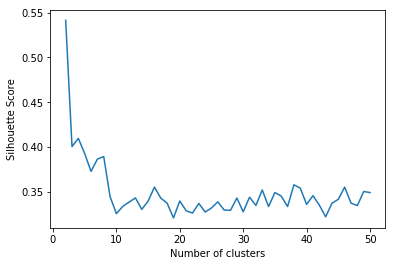

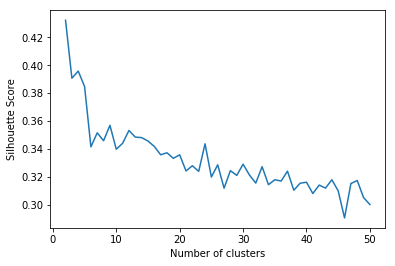

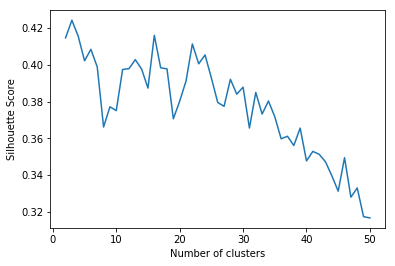

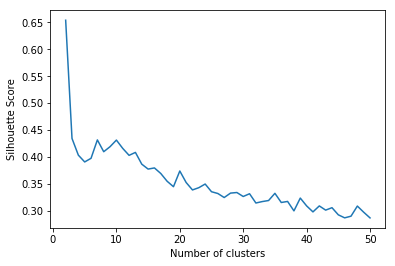

In [26]:
import numpy as np 
import sklearn.metrics as metrics 
import matplotlib.pyplot as plt 
%matplotlib inline 
     
def sc_evaluate_clusters(X,max_clusters): 
    s = np.zeros(max_clusters+1) 
    s[0] = 0; 
    s[1] = 0; 
    for k in range(2,max_clusters+1): 
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10) 
        kmeans.fit_predict(X) 
        s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='euclidean') 
    plt.plot(range(2,len(s)),s[2:]) 
    plt.xlabel('Number of clusters') 
    plt.ylabel('Silhouette Score') 
         
sc_evaluate_clusters(df1[['crime_count','latitude','longitude']],50) 
plt.show() 
sc_evaluate_clusters(df1[['open_count','latitude','longitude']],50) 
plt.show() 
sc_evaluate_clusters(df1[['hubway_count','latitude','longitude']],50) 
plt.show() 
sc_evaluate_clusters(df1[['charge_count','latitude','longitude']], 50)